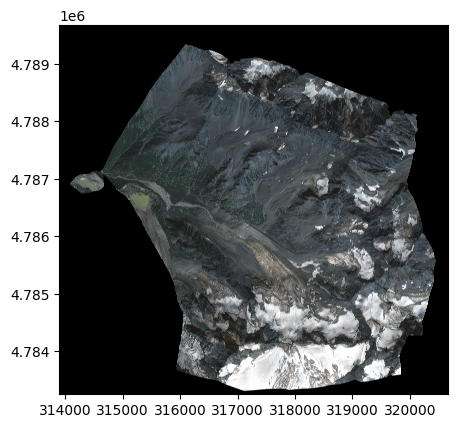

In [3]:
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt
import cv2

img = rasterio.open('D:\Dzhan\ortho_visbands_py_2.tif')
show(img)
full_img = img.read()  #Note the 3 bands and shape of image
#X and Y are supposed to be latitude and longitude if you have the right metadata

In [ ]:
%%time
#Plt save
vert_px = full_img.shape[1]
gor_px = full_img.shape[2]
for i in range(0, gor_px, 500):
    for j in range(0, vert_px, 500):
        clipped_img = full_img[:,j:j+500, i:i+500]
        r = clipped_img[0, :, :]
        g = clipped_img[1, :, :]
        b = clipped_img[2, :, :]
        rgb_image = cv2.merge([r,g,b])
        plt.imshow(rgb_image)
        plt.axis('off')
        file_name = f"D:/Segmentation/train/gor{i}_vert{j}.jpg"
        plt.savefig(file_name, bbox_inches='tight', pad_inches=0)

In [28]:
%%time
#Plt_resize
from ultralytics import YOLO
from pathlib import Path
from PIL import Image

path = Path("D:\Dzhan\Parts_500_2")
list_imgs = [p for p in path.iterdir() if p.is_file()]

for img in list_imgs:
    image = Image.open(img)
    resized_image = image.resize((500, 500))
    file_path = str(img).replace('Parts_500_2', 'Parts_resized')
    resized_image.save(file_path)

CPU times: total: 2.55 s
Wall time: 5.65 s


In [32]:
%%time
#cv2 save
vert_px = full_img.shape[1]
gor_px = full_img.shape[2]
for i in range(0, gor_px, 500):
    for j in range(0, vert_px, 500):
        clipped_img = full_img[:,j:j+500, i:i+500]
        r = clipped_img[0, :, :]
        g = clipped_img[1, :, :]
        b = clipped_img[2, :, :]
        rgb_image = cv2.merge([r,g,b])
        resized_image = cv2.resize(rgb_image, (500, 500))
        file_name = f"D:/Dzhan/Parts_resized_cv2/gor{i}_vert{j}.jpg"
        cv2.imwrite(file_name, resized_image)

CPU times: total: 3.12 s
Wall time: 3.18 s


In [2]:
%%time
from ultralytics import YOLO
from pathlib import Path

path = Path("D:\Dzhan\Parts_resized")
list_imgs = [p for p in path.iterdir() if p.is_file()]

model = YOLO("D:\Segmentation\custom_contr.pt")

results = model.predict(list_imgs, save=True, save_txt=True, project="D:\Dzhan\Parts_resized", agnostic_nms=True, device='cpu')


0: 640x640 1 Rockfall, 6697.2ms
1: 640x640 1 Glacio, 6697.2ms
2: 640x640 1 Glacio, 6697.2ms
3: 640x640 1 Glacio, 2 Rockfalls, 6697.2ms
4: 640x640 1 Glacio, 1 Rockfall, 6697.2ms
5: 640x640 1 Glacio, 1 Rockfall, 6697.2ms
6: 640x640 1 Glacio, 1 Rockfall, 6697.2ms
7: 640x640 1 Glacio, 6697.2ms
8: 640x640 1 Glacio, 1 Rockfall, 6697.2ms
9: 640x640 2 Glacios, 1 Rockfall, 6697.2ms
10: 640x640 2 Glacios, 6697.2ms
11: 640x640 1 Glacio, 1 Rockfall, 6697.2ms
12: 640x640 1 Creep_big, 1 Rockfall, 6697.2ms
13: 640x640 3 Rockfalls, 1 Sheetwash, 6697.2ms
14: 640x640 2 Sheetwashs, 6697.2ms
15: 640x640 1 Glacio, 6697.2ms
16: 640x640 1 Glacio, 3 Rockfalls, 1 Sheetwash, 6697.2ms
17: 640x640 1 Glacio, 6697.2ms
18: 640x640 3 Glacios, 6697.2ms
19: 640x640 1 Glacio, 1 Rockfall, 6697.2ms
20: 640x640 1 Creep_big, 1 Rockfall, 2 Sheetwashs, 6697.2ms
21: 640x640 1 Creep_big, 2 Glacios, 1 Rockfall, 6697.2ms
22: 640x640 1 Glacio, 1 Rockfall, 1 Sheetwash, 6697.2ms
23: 640x640 1 Lake, 1 River, 2 Stables, 6697.2ms
24: 

In [3]:
import pandas as pd

train = pd.DataFrame(columns={'x': int, 
                              'y': int, 
                              'Creep_big': float,
                              'Creep_small': float, 
                              'Erosion': float, 
                              'Glacio': float, 
                              'Lake': float, 
                              'River': float, 
                              'Rockfall': float, 
                              'Sheetwash': float, 
                              'Stable': float})

In [88]:
%%time
from shapely.strtree import STRtree
import numpy as np
tree = STRtree(np.array([Polygon(i) for i in polygons]))
query_points = np.array(point_list)
# indices = [''.join(spisok_proc[i] for i in tree.query_nearest(point, max_distance = 0.0001)) for point in query_points]
[i for point in query_points for i in tree.query_nearest(Point(point), max_distance = 0.0001)]

CPU times: total: 46.9 ms
Wall time: 55.3 ms


In [106]:
%%time
from shapely import Polygon, Point, contains_xy
from itertools import product, chain
import threading
import statistics
import re

count = 0
test_try = []
comb_points = product([i for i in range(results[0].orig_img.shape[1])], [i for i in range(results[0].orig_img.shape[0])])
point_list = list(comb_points)

def contain_point(points):
    res_poly = [{res.names[int(res.boxes.cls[k])]: float(res.boxes.conf[k]) * contains_xy(Polygon(poli), points[0], points[1])} for k, poli in enumerate(polygons)] 
    return res_poly
    
for res in results:
    count += 1
    print(count)
    if len(res) > 0:
        polygons = res.masks.xy
        points_1000 = point_list
            
        result = list(map(contain_point, points_1000))
        
        test_try += [{j:statistics.mean([i[j] for i in k if j in i]) if len([i[j] for i in k if j in i]) > 0 else 0 for j in res.names.values()} for k in result]
    else:
        test_try += [{j:0 for j in res.names.values()} for k in result]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [107]:
%%time
import csv

def save_list_of_dicts_to_csv(data, filename):
    """
    Сохраняет список словарей в CSV файл, по строкам.

    Args:
        data: Список словарей.
        filename: Имя файла для сохранения.
    """
    if not data:
        return

    # Извлечение ключей (заголовков столбцов) из первого словаря.
    fieldnames = list(data[0].keys())

    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Запись заголовков столбцов
        writer.writeheader()

        # Запись данных
        writer.writerows(data)

# Использование функции
filename = 'E:\Dzhan_aug\Dzhan_img.csv'
save_list_of_dicts_to_csv(test_try, filename)

print(f"Данные успешно сохранены в {filename}")

Данные успешно сохранены в E:\Dzhan_aug\Dzhan_img.csv
CPU times: total: 8min 35s
Wall time: 10min


In [108]:
%%time
import pandas as pd
import numpy as np

data_types = {'x': pd.Series(dtype=np.uint16), 
        'y': pd.Series(dtype=np.uint16), 
        'Creep_big': pd.Series(dtype=np.float16),
        'Creep_small': pd.Series(dtype=np.float16), 
        'Erosion': pd.Series(dtype=np.float16), 
        'Glacio': pd.Series(dtype=np.float16), 
        'Lake': pd.Series(dtype=np.float16), 
        'River': pd.Series(dtype=np.float16), 
        'Rockfall': pd.Series(dtype=np.float16), 
        'Sheetwash': pd.Series(dtype=np.float16), 
        'Stable': pd.Series(dtype=np.float16)}

data = pd.read_csv('E:\Dzhan_aug\Dzhan_img.csv')
# data = pd.read_csv('E:\Dzhan_aug\Dzhan_img.csv', dtype = data_types)

CPU times: total: 1min 3s
Wall time: 1min 6s


In [110]:
data.to_parquet('E:\Dzhan_aug\Dzhan_img.parquet', index=False)

In [1]:
import pandas as pd
data = pd.read_parquet('E:\Dzhan_aug\Dzhan_img.parquet')

In [ ]:
del test_try
del full_img

In [4]:
%%time
from pathlib import Path
import re

path = Path("D:\Dzhan\Parts_resized")
list_imgs = [p for p in path.iterdir() if p.is_file()]
x_corner = [int([re.sub(r'[^\d]', '', m) for m in str(str(res).rsplit('.', 1)[0].split('\\')[-1]).split('_')][0]) for res in list_imgs]
y_corner = [int([re.sub(r'[^\d]', '', m) for m in str(str(res).rsplit('.', 1)[0].split('\\')[-1]).split('_')][1]) for res in list_imgs]

CPU times: total: 78.1 ms
Wall time: 115 ms


In [5]:
%%time
from itertools import chain, product
import itertools
xs = list(chain.from_iterable([list(itertools.repeat(i, 500)) for i in range(500)]))
ys = [i for i in range(500)] * 500

CPU times: total: 15.6 ms
Wall time: 7.42 ms


In [6]:
%%time
x_pairs = list(product(x_corner, xs))
y_pairs = list(product(y_corner, ys))

CPU times: total: 28 s
Wall time: 28.1 s


In [7]:
%%time
def two_sum(a, b):
    return a + b
    
x_list_iter = list(itertools.starmap(two_sum, x_pairs))
y_list_iter = list(itertools.starmap(two_sum, y_pairs))

CPU times: total: 56.6 s
Wall time: 1min 8s


In [8]:
%%time
data['x'] = x_list_iter
data['y'] = y_list_iter

CPU times: total: 1min 26s
Wall time: 1min 32s


In [71]:
%%time
data.to_csv('E:\Dzhan_aug\Dzhan_xy.csv', index=False)

CPU times: total: 6min 47s
Wall time: 6min 54s


In [11]:
%%time
data.to_parquet('E:\Dzhan_aug\Dzhan_xy.parquet', index=False)

CPU times: total: 1min
Wall time: 55.3 s


In [1]:
from shapely import Polygon, Point, contains_xy
from shapely.ops import unary_union
from affine import Affine
import geopandas as gpd
from rasterstats import point_query
from osgeo import gdal
import pandas as pd
from itertools import chain
import numpy as np

In [2]:
%%time
#Открываем все нужные слои и полученный датафрейм на этапе 1)
dem = gdal.Open("D:\Dzhan\DEMetAll\DEM_Dzhan.tif", gdal.GA_ReadOnly)
slope = gdal.Open("D:\Dzhan\DEMetAll\Slope_Dzhan.tif", gdal.GA_ReadOnly)
TWI = gdal.Open("D:\Dzhan\DEMetAll\TWI_Dzhan.tif", gdal.GA_ReadOnly)
TPI = gdal.Open("D:\Dzhan\DEMetAll\TPI_Dzhan.tif", gdal.GA_ReadOnly)
TCA = gdal.Open("D:\Dzhan\DEMetAll\TCA_Dzhan.tif", gdal.GA_ReadOnly)
aspect = gdal.Open("D:\Dzhan\DEMetAll\Aspect_Dzhan.tif", gdal.GA_ReadOnly)
network_dist = gdal.Open("D:\Dzhan\DEMetAll\Channel_Network_Distance_Dzhan.tif", gdal.GA_ReadOnly)
landforms = gdal.Open("D:\Dzhan\DEMetAll\Landforms_Dzhan.tif", gdal.GA_ReadOnly)
valley_depth = gdal.Open("D:\Dzhan\DEMetAll\Valley_Depth_Dzhan.tif", gdal.GA_ReadOnly)
profile_curvature = gdal.Open("D:\Dzhan\DEMetAll\Profile_Curvature_Dzhan.tif", gdal.GA_ReadOnly)

orto_photo = gdal.Open('D:\Dzhan\ortho_visbands_py_2.tif', gdal.GA_ReadOnly)
# Read the shapefile
# polygon = gpd.read_file("D:\Donguz\processes_dif_erosion.shp")

#Считываем данных с первого кода
# train = pd.read_csv('E:\Donguz_data_xy.csv')
train = pd.read_parquet('E:\Dzhan_aug\Dzhan_xy.parquet')

CPU times: total: 1min 10s
Wall time: 14 s


In [3]:
%%time
#Особенности проекции ЦМР и ортофотоплана для расчета координат точек
gt_orto = orto_photo.GetGeoTransform()
gt = dem.GetGeoTransform()

# Слой высот
dem_data = dem.ReadAsArray()
slope_data = slope.ReadAsArray()
TWI_data = TWI.ReadAsArray()
TPI_data = TPI.ReadAsArray()
TCA_data = TCA.ReadAsArray()
aspect_data = aspect.ReadAsArray()
network_dist_data = network_dist.ReadAsArray()
landforms_data = landforms.ReadAsArray()
valley_depth_data = valley_depth.ReadAsArray()
profile_curvature_data = profile_curvature.ReadAsArray()

CPU times: total: 8.77 s
Wall time: 11.1 s


In [4]:
%%time
x_orto = train['x'] * gt_orto[1] + gt_orto[0] #Координата X точек, взятых на ортофотоплане для текстурных осоенностей
y_orto = train['y'] * gt_orto[5] + gt_orto[3] #Координата Y точек, взятых на ортофотоплане для текстурных осоенностей

CPU times: total: 4.56 s
Wall time: 4.86 s


In [5]:
%%time
x_dem = round((x_orto - gt[0])/gt[1]) #Координата X точек в пикселях на ЦМР
y_dem = round((y_orto - gt[3])/gt[5]) #Координата Y точек в пикселях на ЦМР

CPU times: total: 2.55 s
Wall time: 2.6 s


In [6]:
%%time
x_max = dem_data.shape[1]
y_max = dem_data.shape[0]

CPU times: total: 0 ns
Wall time: 0 ns


In [7]:
%%time
dem_list = [dem_data[int(y_dem[i]), int(x_dem[i])] if (x_dem[i] < x_max and y_dem[i] < y_max) else -1 for i in range(len(x_dem))]
train['Elev'] = dem_list
del dem_list

CPU times: total: 15min 53s
Wall time: 16min 2s


In [8]:
%%time
slope_list = [slope_data[int(y_dem[i]), int(x_dem[i])] if (x_dem[i] < x_max and y_dem[i] < y_max) else -1 for i in range(len(x_dem))]
train['Slope'] = slope_list
del slope_list

CPU times: total: 15min 51s
Wall time: 15min 58s


In [ ]:
%%time
TWI_list = [TWI_data[int(y_dem[i]), int(x_dem[i])] if (x_dem[i] < x_max and y_dem[i] < y_max) else -1 for i in range(len(x_dem))]
train['TWI'] = TWI_list
del TWI_list

In [ ]:
%%time
TPI_list = [TPI_data[int(y_dem[i]), int(x_dem[i])] if (x_dem[i] < x_max and y_dem[i] < y_max) else -1 for i in range(len(x_dem))]
train['TPI'] = TPI_list
del TPI_list

In [ ]:
%%time
TCA_list = [TCA_data[int(y_dem[i]), int(x_dem[i])] if (x_dem[i] < x_max and y_dem[i] < y_max) else -1 for i in range(len(x_dem))]
train['TCA'] = TCA_list
del TCA_list

In [ ]:
%%time
aspect_list = [aspect_data[int(y_dem[i]), int(x_dem[i])] if (x_dem[i] < x_max and y_dem[i] < y_max) else -1 for i in range(len(x_dem))]
train['Aspect'] = aspect_list
del aspect_list

In [ ]:
%%time
network_dist_list = [network_dist_data[int(y_dem[i]), int(x_dem[i])] if (x_dem[i] < x_max and y_dem[i] < y_max) else -1 for i in range(len(x_dem))]
train['Network_distance'] = network_dist_list
del network_dist_list

In [ ]:
%%time
landforms_list = [landforms_data[int(y_dem[i]), int(x_dem[i])] if (x_dem[i] < x_max and y_dem[i] < y_max) else -1 for i in range(len(x_dem))]
train['Landforms'] = landforms_list
del landforms_list

In [ ]:
%%time
valley_depth_list = [valley_depth_data[int(y_dem[i]), int(x_dem[i])] if (x_dem[i] < x_max and y_dem[i] < y_max) else -1 for i in range(len(x_dem))]
train['Valley_depth'] = valley_depth_list
del valley_depth_list

In [ ]:
%%time
profile_curvature_list = [profile_curvature_data[int(y_dem[i]), int(x_dem[i])] if (x_dem[i] < x_max and y_dem[i] < y_max) else -1 for i in range(len(x_dem))]
train['Profile_curvature'] = profile_curvature_list
del profile_curvature_list

In [6]:
%%time
data_types = {'x': np.uint16, 
        'y': np.uint16, 
        'Creep_big': np.float16,
        'Creep_small': np.float16, 
        'Erosion': np.float16, 
        'Glacio': np.float16, 
        'Lake': np.float16, 
        'River': np.float16, 
        'Rockfall': np.float16, 
        'Sheetwash': np.float16, 
        'Stable': np.float16, 
        'Elev': np.float32,
        'Slope': np.float32,
        'TWI': np.float32,
        'TPI': np.float32,
        'TCA': np.float32,
        'Aspect': np.float32, 
        'Network_distance': np.float32,
        'Landforms': np.uint16,
        'Valley_depth': np.float32,
        'Profile_curvature': np.float32}

train_less = train.astype(data_types)

CPU times: total: 20.4 s
Wall time: 31.5 s


In [8]:
%%time
train_less.to_parquet('E:\Dzhan\Dzhan_full_less.parquet', index=False)

CPU times: total: 1min 33s
Wall time: 1min 33s


In [23]:
%%time
data_pd_clear = pd.read_parquet('E:\Dzhan\Dzhan_full_less.parquet')

CPU times: total: 1min 29s
Wall time: 47.4 s


In [27]:
data_pd_clear_true = data_pd_clear[(data_pd_clear['Landforms'] != 255) & (data_pd_clear['Landforms'] != 65535)]
# data_pd_clear_true = data_pd_clear_true.drop('index', axis=1)

In [32]:
%%time
data_pd_clear_true.to_parquet('E:\Dzhan\Dzhan_test_xy.parquet', index=False)
# data_pd_clear_true.to_csv('E:\Donguz_train_process_xy.csv', index=False)

CPU times: total: 1min 2s
Wall time: 1min 13s


In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import  roc_auc_score, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
%%time
X_train = pd.read_parquet('E:\Donguz_train_process_xy.parquet')

CPU times: total: 34.2 s
Wall time: 28.8 s


In [3]:
%%time
y_train = pd.read_parquet('E:\Donguz_train_process_xy.parquet', columns = ['Process'])

CPU times: total: 797 ms
Wall time: 536 ms


In [4]:
%%time
X_test = pd.read_parquet('E:\Dzhan\Dzhan_test_xy.parquet')

CPU times: total: 56.8 s
Wall time: 36.6 s


In [5]:
del X_train['x']
del X_train['y']
del X_train['Process']

In [6]:
del X_test['x']
del X_test['y']

In [7]:
X_train.columns

Index(['Creep_big', 'Creep_small', 'Erosion', 'Glacio', 'Lake', 'River',
       'Rockfall', 'Sheetwash', 'Stable', 'Elev', 'Slope', 'TWI', 'TPI', 'TCA',
       'Aspect', 'Network_distance', 'Landforms', 'Valley_depth',
       'Profile_curvature'],
      dtype='object')

In [8]:
X_test.columns

Index(['Creep_big', 'Creep_small', 'Erosion', 'Glacio', 'Lake', 'River',
       'Rockfall', 'Sheetwash', 'Stable', 'Elev', 'Slope', 'TWI', 'TPI', 'TCA',
       'Aspect', 'Network_distance', 'Landforms', 'Valley_depth',
       'Profile_curvature'],
      dtype='object')

In [9]:
y = np.ravel(y_train)

In [10]:
%%time
clf = RandomForestClassifier(n_estimators=100, verbose = 3)

clf.fit(X_train, y)
y_pred = clf.predict(X_test)

CPU times: total: 9h 3min 7s
Wall time: 9h 43min 26s


КОНЕЦ

In [29]:
%%time
clf2 = RandomForestClassifier(n_estimators=100, verbose = 3)
clf2.fit(X_train[0:1_000_000], y[0:1_000_000])

In [24]:
%%time
# load
with open('E:\Dzhan\Dzhan_elev_100_estimators.pkl', 'rb') as f:
    clf2 = pickle.load(f)

y_pred_2 = clf2.predict(X_test)

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
import pickle
# save
with open('E:\Dzhan\Dzhan_elev_100_estimators.pkl','wb') as f:
    pickle.dump(clf,f)

In [ ]:
from joblib import dump, load
# dump(clf, 'filename.joblib') 

clf = load('filename.joblib') 

ТУТ НАЧИНАТЬ

In [11]:
%%time
y_pred_df = pd.DataFrame(columns = {'Prediction': 'category'})
y_pred_df['Prediction'] = y_pred
y_pred_df['Prediction'] = y_pred_df['Prediction'].astype('category')

CPU times: total: 14.2 s
Wall time: 14.5 s


In [12]:
%%time
y_pred_df.to_parquet('E:\Dzhan\Dzhan_prediction_elev.parquet', index=False)

CPU times: total: 1.5 s
Wall time: 2.44 s


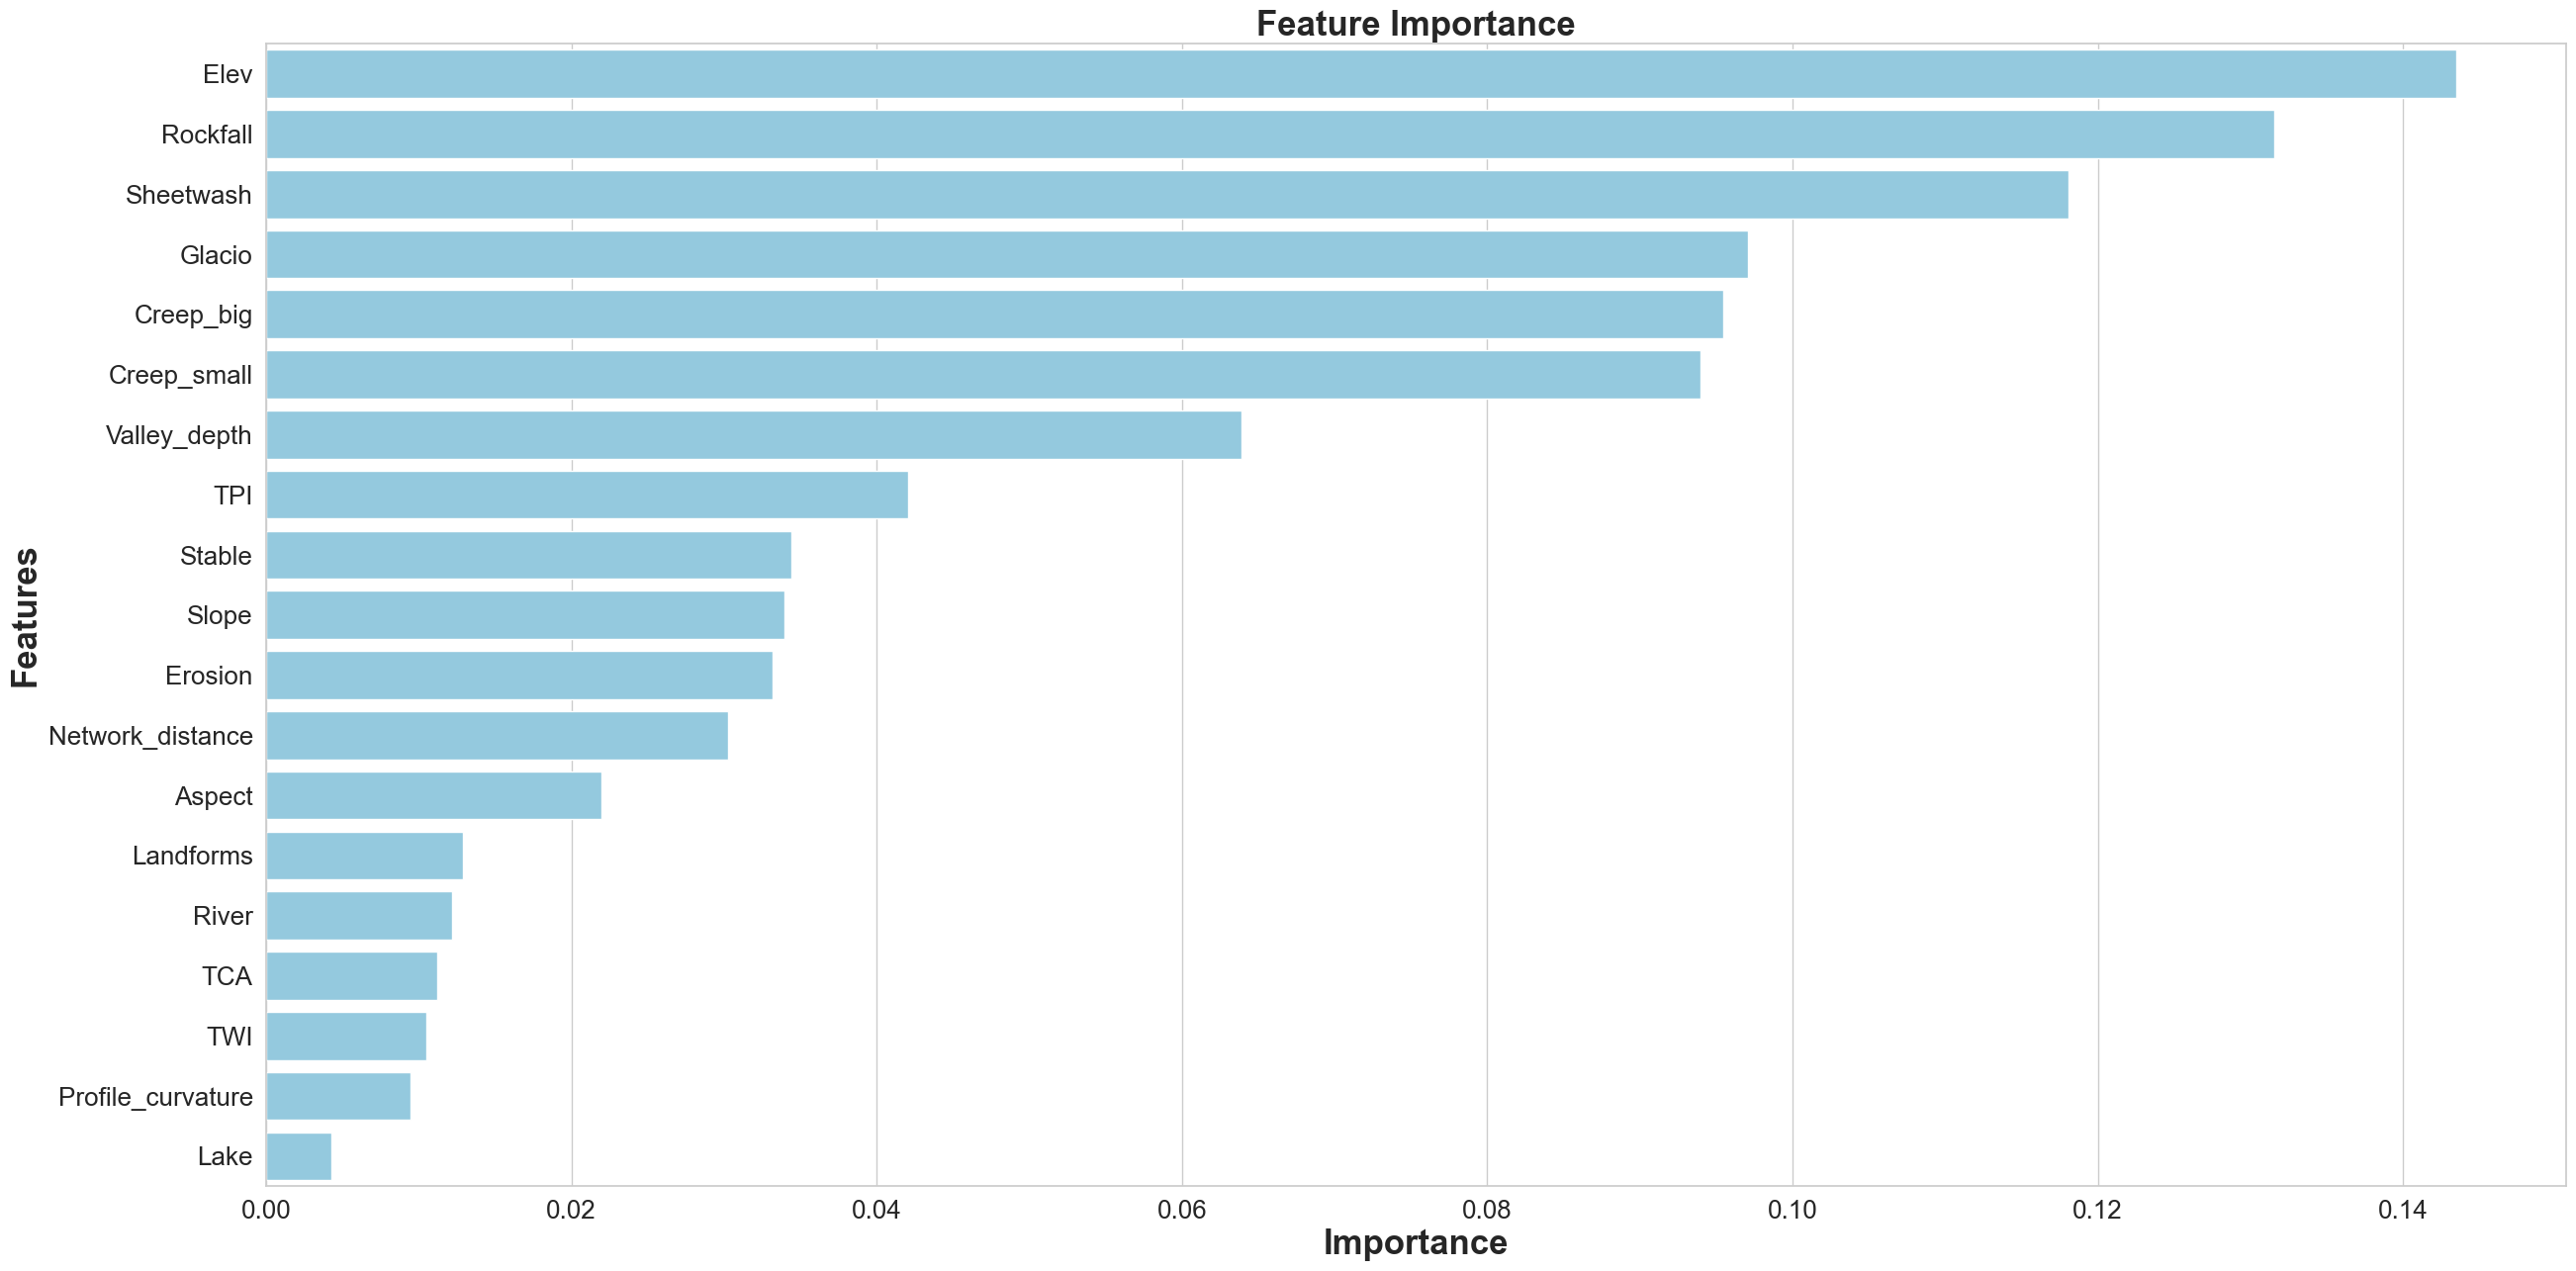

None

,Features,Gini-Importance
0,Elev,0.143499
1,Rockfall,0.131574
2,Sheetwash,0.118090
3,Glacio,0.097098
4,Creep_big,0.095442
5,Creep_small,0.093946
6,Valley_depth,0.063905
7,TPI,0.042063
8,Stable,0.034433
9,Slope,0.033965


In [13]:
feats = {}
for feature, importance in zip(X_train.columns, clf.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

In [14]:
from osgeo import gdalconst
from osgeo import gdal
orto_photo = gdal.Open('D:\Dzhan\ortho_visbands_py_2.tif', gdal.GA_ReadOnly)

In [15]:
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt
import cv2

img = rasterio.open('D:\Dzhan\ortho_visbands_py_2.tif')
full_img = img.read()  #Note the 3 bands and shape of image

In [16]:
%%time
y_pred_df_tif = pd.read_parquet('E:\Dzhan\Dzhan_prediction_elev.parquet')

CPU times: total: 1.42 s
Wall time: 1.93 s


In [17]:
%%time
data_xy = pd.read_parquet('E:\Dzhan\Dzhan_test_xy.parquet', columns = ['x', 'y'])

CPU times: total: 1 s
Wall time: 1.54 s


In [18]:
replacement = {'Комплекс ледниковых и водно-ледниковых аккумулятивно-денудационных процессов': 1,
               'Крип и солифлюкция толщи мелкозема': 2,
               'Крип толщи грубообломочного материала': 3,
               'Линейная эрозия': 4,
               'Обвалы и осыпи': 5,
               'Озерная аккумуляция': 6,
               'Плоскостная и ручейковая эрозия': 7,
               'Условно стабильные поверхности': 8,
               'Эрозионно-аккумулятивные процессы в руслах, на поймах и дельтах':9}
y_pred_int = y_pred_df_tif.replace(replacement)

C:\Users\vikma\AppData\Local\Temp\ipykernel_7648\4074818432.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_pred_int = y_pred_df_tif.replace(replacement)
C:\Users\vikma\AppData\Local\Temp\ipykernel_7648\4074818432.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y_pred_int = y_pred_df_tif.replace(replacement)


In [19]:
data_result = np.zeros(full_img.shape[1:3])

In [20]:
%%time
y = list(data_xy['y'])
x = list(data_xy['x'])
for i in range(len(data_xy)):
    data_result[y[i], x[i]] = y_pred_int['Prediction'][i]

CPU times: total: 9min 42s
Wall time: 9min 44s


In [21]:
%%time
# 1. Создаем массив NumPy
data = data_result  # Пример матрицы

# 2. Определяем параметры GeoTIFF
width = full_img.shape[2]
height = full_img.shape[1]
driver = gdal.GetDriverByName('GTiff')  # Используем драйвер GeoTIFF
output_filename = 'D:\Dzhan\process_elev.tif'  # Название выходного файла
projection = orto_photo.GetProjection() # Пример проекции (выберите подходящую)
# projection = 'EPSG:32638'  
geoTransform = orto_photo.GetGeoTransform()

# 3. Создаем GeoTIFF
dataset = driver.Create(output_filename, width, height, 1, gdalconst.GDT_Int16)  # 1 - количество слоев, gdalconst.GDT_Float32 - тип данных

# 4. Устанавливаем проекцию
dataset.SetProjection(projection)

# 5. Устанавливаем геодезические трансформации
dataset.SetGeoTransform(geoTransform)

# 6. Записываем данные
band = dataset.GetRasterBand(1)  # Получаем первый слой
band.WriteArray(data)  # Записываем матрицу
band.FlushCache()  # Очистка кеша

# 7. Закрываем файл
dataset = None  # Завершаем работу с файлом

CPU times: total: 1.19 s
Wall time: 1.35 s
